# 1. Environment setup and data preparation

In [ ]:
#!pip install transformers datasets scikit-learn pandas tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/SPH6004-group assignment/mimic-cxr-reports.zip"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: files/p13/p13989300/s51173922.txt  
   creating: files/p13/p13664951/
  inflating: files/p13/p13664951/s53174477.txt  
  inflating: files/p13/p13664951/s59971272.txt  
  inflating: files/p13/p13664951/s59776531.txt  
   creating: files/p13/p13162864/
  inflating: files/p13/p13162864/s58968783.txt  
   creating: files/p13/p13138256/
  inflating: files/p13/p13138256/s53796371.txt  
   creating: files/p13/p13349882/
  inflating: files/p13/p13349882/s51884101.txt  
   creating: files/p13/p13558272/
  inflating: files/p13/p13558272/s58519040.txt  
   creating: files/p13/p13139059/
  inflating: files/p13/p13139059/s58456977.txt  
  inflating: files/p13/p13139059/s53760808.txt  
  inflating: files/p13/p13139059/s59925397.txt  
   creating: files/p13/p13496169/
  inflating: files/p13/p13496169/s58654265.txt  
  inflating: files/p13/p13496169/s50627096.txt  
  inflating: files/p13/p13496169/s57048001.txt  
  inflating: files/p13/p13496169/s50868325.txt  


In [ ]:
reports_dir = "/content/files"
csv_file = "/content/drive/MyDrive/SPH6004-group assignment/mimic-cxr-2.0.0-chexpert.csv"


# 2. Test data loading and directory structure viewing

In [ ]:
import os

for subfolder1 in os.listdir(reports_dir):
    subfolder1_path = os.path.join(reports_dir, subfolder1)
    if os.path.isdir(subfolder1_path):
        print(f"🔹 {subfolder1}/")
        for subfolder2 in os.listdir(subfolder1_path):
            subfolder2_path = os.path.join(subfolder1_path, subfolder2)
            print(f"    └── {subfolder2}/")
            for file in os.listdir(subfolder2_path):
                if file.endswith(".txt"):
                    print(f"        📄 {file}")
                    break
            break


🔹 p12/
    └── p12009234/
        📄 s57843422.txt
🔹 p17/
    └── p17580970/
        📄 s50504579.txt
🔹 p13/
    └── p13087032/
        📄 s58011624.txt
🔹 p16/
    └── p16787597/
        📄 s55697863.txt
🔹 p11/
    └── p11831106/
        📄 s58205085.txt
🔹 p19/
    └── p19832055/
        📄 s56170913.txt
🔹 p15/
    └── p15928183/
        📄 s58165019.txt
🔹 p18/
    └── p18246530/
        📄 s53953807.txt
🔹 p14/
    └── p14191651/
        📄 s50584021.txt
🔹 p10/
    └── p10203426/
        📄 s59622974.txt


# 3. Data preprocessing and label conversion

In [ ]:
print(f"Reports directory: {reports_dir}")
import os
import pandas as pd
for subfolder1 in os.listdir(reports_dir):
    print(subfolder1)

Reports directory: /content/files
p12
p17
p13
p16
p11
p19
p15
p18
p14
p10


In [ ]:
import os
import pandas as pd

df = pd.read_csv(csv_file)
df = df.fillna(0)
df.replace(-1, 0, inplace=True)
labels = df.columns[2:]

def read_report_text(row):
    subject_id = str(row['subject_id']).zfill(8)
    study_id = str(row['study_id'])
    report_path = os.path.join(
        reports_dir,
        f"p{subject_id[:2]}",
        f"p{subject_id}",
        f"s{study_id}.txt"
    )
    try:
        with open(report_path, "r") as file:
            return file.read()
    except FileNotFoundError:
        return

In [ ]:
df["report_path"] = df.apply(lambda row: os.path.join(
    reports_dir,
    f"p{str(row['subject_id']).zfill(8)[:2]}",
    f"p{str(row['subject_id']).zfill(8)}",
    f"s{int(row['study_id'])}.txt"
), axis=1)

print(df["report_path"].head())


0    /content/files/p10/p10000032.0/s50414267.txt
1    /content/files/p10/p10000032.0/s53189527.txt
2    /content/files/p10/p10000032.0/s53911762.txt
3    /content/files/p10/p10000032.0/s56699142.txt
4    /content/files/p10/p10000764.0/s57375967.txt
Name: report_path, dtype: object


In [ ]:
df['report_text'] = df.apply(read_report_text, axis=1)

# 4. Data loading and preparation

In [ ]:
import os
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


df = pd.read_csv(csv_file)
df = df.fillna(0)
df.replace(-1, 0, inplace=True)
print(df.head())

labels = df.columns[2:]
target_names = labels.tolist()
label_counts = df[labels].sum(axis=0)
total_counts = len(df)
label_counts = label_counts.replace(0, 1)
pos_weights = torch.tensor((total_counts - label_counts) / label_counts).float().to(device)

   subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0    10000032  50414267          0.0           0.0            0.0    0.0   
1    10000032  53189527          0.0           0.0            0.0    0.0   
2    10000032  53911762          0.0           0.0            0.0    0.0   
3    10000032  56699142          0.0           0.0            0.0    0.0   
4    10000764  57375967          0.0           0.0            1.0    0.0   

   Enlarged Cardiomediastinum  Fracture  Lung Lesion  Lung Opacity  \
0                         0.0       0.0          0.0           0.0   
1                         0.0       0.0          0.0           0.0   
2                         0.0       0.0          0.0           0.0   
3                         0.0       0.0          0.0           0.0   
4                         0.0       0.0          0.0           0.0   

   No Finding  Pleural Effusion  Pleural Other  Pneumonia  Pneumothorax  \
0         1.0               0.0            0.0 

<ipython-input-9-330c82f4ec1d>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pos_weights = torch.tensor((total_counts - label_counts) / label_counts).float().to(device)


In [ ]:
print(f"number of labels: {len(target_names)}")
print(target_names)

number of labels: 14
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']


In [ ]:
def build_report_path(row):
    subject_id_str = str(int(row["subject_id"])).zfill(8)
    study_id_str = str(int(row["study_id"]))
    path = os.path.join(
        reports_dir,
        f"p{subject_id_str[:2]}",
        f"p{subject_id_str}",
        f"s{study_id_str}.txt"
    )
    return path

df["report_path"] = df.apply(build_report_path, axis=1)
def read_report_text(row):
    try:
        with open(row["report_path"], "r") as f:
            return f.read()
    except FileNotFoundError:
        return
df["report_text"] = df.apply(read_report_text, axis=1)
print(df[["subject_id", "study_id", "report_path", "report_text"]].head())
df.head()

   subject_id  study_id                                 report_path  \
0    10000032  50414267  /content/files/p10/p10000032/s50414267.txt   
1    10000032  53189527  /content/files/p10/p10000032/s53189527.txt   
2    10000032  53911762  /content/files/p10/p10000032/s53911762.txt   
3    10000032  56699142  /content/files/p10/p10000032/s56699142.txt   
4    10000764  57375967  /content/files/p10/p10000764/s57375967.txt   

                                         report_text  
0                                   FINAL REPORT\...  
1                                   FINAL REPORT\...  
2                                   FINAL REPORT\...  
3                                   FINAL REPORT\...  
4                                   FINAL REPORT\...  


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,report_path,report_text
0,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/files/p10/p10000032/s50414267.txt,FINAL REPORT\...
1,10000032,53189527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/files/p10/p10000032/s53189527.txt,FINAL REPORT\...
2,10000032,53911762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/files/p10/p10000032/s53911762.txt,FINAL REPORT\...
3,10000032,56699142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/files/p10/p10000032/s56699142.txt,FINAL REPORT\...
4,10000764,57375967,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/files/p10/p10000764/s57375967.txt,FINAL REPORT\...


# 5. Modelling

## 5.1 Define dataset class

In [ ]:
from torch.utils.data import Dataset
from transformers import BertTokenizer

class CheXpertDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.texts = df['report_text'].tolist()
        self.labels = df[labels].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item


## 5.2 Define the model and loss function

model.py：BERT

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.6.0+cu124
12.4


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class CheXpertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(CheXpertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)  # 输出层

    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        cls_output = outputs.pooler_output

        logits = self.fc(cls_output)
        return logits

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', pos_weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none', pos_weight=self.pos_weight
        )
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma

        loss = self.alpha * focal_term * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


#6. Model Training and Evaluation

In [ ]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
import numpy as np

tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = CheXpertClassifier(num_labels=len(labels))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# initialize
train_dataset = CheXpertDataset(train_df, tokenizer)
val_dataset = CheXpertDataset(val_df, tokenizer)

batch_size = 64

#optimize
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=3,
    persistent_workers=True if num_workers > 0 else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size*2,
    num_workers=2,
    pin_memory=True
)


optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5)

from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(train_loader) * epochs


num_warmup_steps = int(0.1 * total_steps)
num_training_steps = total_steps * 2

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)


loss_fn = FocalLoss(alpha=1, gamma=2, pos_weight=pos_weights)

# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)
scaler = GradScaler()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

<ipython-input-18-32c1b8fd72a6>:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=3):
    best_val_f1 = 0
    history = {'train_loss': [], 'val_f1': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Training]', leave=False)

        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(input_ids, attention_mask)
                loss = loss_fn(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'batch_loss': f'{loss.item():.4f}'})

        avg_train_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)


        val_f1 = evaluate_model(model, val_loader, device)
        history['val_f1'].append(val_f1)


        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'\nEpoch {epoch+1} Summary:')
        print(f'Train Loss: {avg_train_loss:.4f} | Val F1: {val_f1:.4f}')
        print('-'*50)

        print(f"Current LR: {scheduler.get_last_lr()[0]:.2e}")


    return history

In [ ]:
from sklearn.metrics import f1_score
import torch

@torch.no_grad()
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    for batch in tqdm(data_loader, desc='Evaluating', leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(input_ids, attention_mask)

        probs = torch.sigmoid(logits)
        threshold = 0.3
        preds = (probs > threshold).int()

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)


    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
    return f1

In [ ]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

61

Streaming output truncated to the last 5000 lines.
Streaming output truncated to the last 5000 lines.
Epoch 1/3 [Training]: 100%|██████████| 2848/2848 [1:08:10<00:00,  1.36s/it, batch_loss=0.0184]



Epoch 1 Summary:
Train Loss: 0.0743 | Val F1: 0.8135
--------------------------------------------------
Current LR: 1.75e-05



Epoch 2 Summary:
Train Loss: 0.0171 | Val F1: 0.8652
--------------------------------------------------
Current LR: 1.40e-05



Epoch 3 Summary:
Train Loss: 0.0112 | Val F1: 0.9181
--------------------------------------------------
Current LR: 1.05e-05

Final Evaluation:


Final Evaluation: 100%|██████████| 356/356 [23:59<00:00,  4.04s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 


Classification Report:
                            precision    recall  f1-score   support

               Atelectasis       0.97      0.99      0.98      9167
              Cardiomegaly       0.97      0.99      0.98      8935
             Consolidation       0.92      0.98      0.95      2136
                     Edema       0.97      0.99      0.98      5393
Enlarged Cardiomediastinum       0.80      0.98      0.88      1469
                  Fracture       0.86      0.99      0.92       850
               Lung Lesion       0.90      0.99      0.94      1314
              Lung Opacity       0.97      0.99      0.98     10367
                No Finding       0.98      0.99      0.99     15074
          Pleural Effusion       0.98      0.99      0.99     10973
             Pleural Other       0.85      0.99      0.92       397
                 Pneumonia       0.78      0.98      0.87      3362
              Pneumothorax       0.94      0.99      0.96      2062
           Support Devi

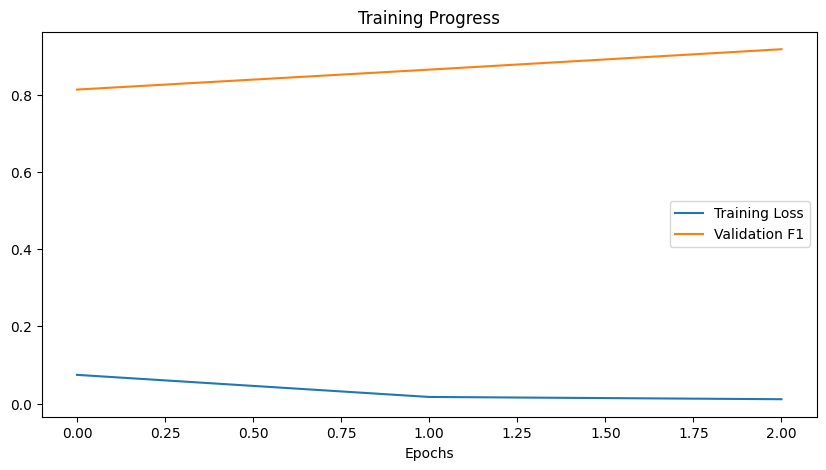

In [ ]:
history = train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=3)

print("\nFinal Evaluation:")
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Final Evaluation'):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)
        preds = torch.sigmoid(logits) > 0.5

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

from sklearn.metrics import classification_report


assert all_preds.shape[1] == len(target_names), "标签数量与预测维度不匹配！"
print("\nClassification Report:")
print(classification_report(all_labels.numpy(), all_preds.numpy(), target_names=target_names))



import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_f1'], label='Validation F1')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
df['report_len'] = df['report_text'].apply(lambda x: len(x.strip()))
print(df['report_len'].describe())
print(df['report_text'].sample(5).tolist())


count    227827.000000
mean        634.276780
std         257.595151
min          98.000000
25%         457.000000
50%         576.000000
75%         750.000000
max        3899.000000
Name: report_len, dtype: float64
['                                 FINAL REPORT\n HISTORY:  Followup pneumothorax.\n \n COMPARISON:  ___ at 14 20.\n \n FINDINGS:\n \n Moderate right pneumothorax is again visualized and is similar size compared\n to prior.  The left pneumothorax is now larger than prior and is now moderate\n in size.  Bilateral pigtail catheters are again visualized.  There has been\n partial re-expansion of the right lower lobe, but there is still RLL volume\n loss medially.  There is volume loss/infiltrate in the left mid lung\n laterally.\n \n IMPRESSION:\n \n Moderate bilateral pneumothoraces.  The pneumothorax on the right is of\n similar size and the pneumothorax on the left is slightly larger.\n', '                                 FINAL REPORT\n EXAMINATION:  CHEST (PORTABLE AP)\n 

It indicates that the length distribution of report_text is very reasonable.
Indicator meaning
min = 148. No blank text (excellent)
mean ≈ 635. The report content is moderate and not too short
max ≈ 2773. There are some extremely long texts, but they are within the normal range
std ≈ 254 indicates that the length fluctuation is moderate and there is no obvious structural anomaly in the reporting style

No changes are needed.

In [ ]:
print(f"label nums: {len(target_names)}")
print(target_names)


label nums: 14
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']


#7. Visualization

## F1-score for each categories

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


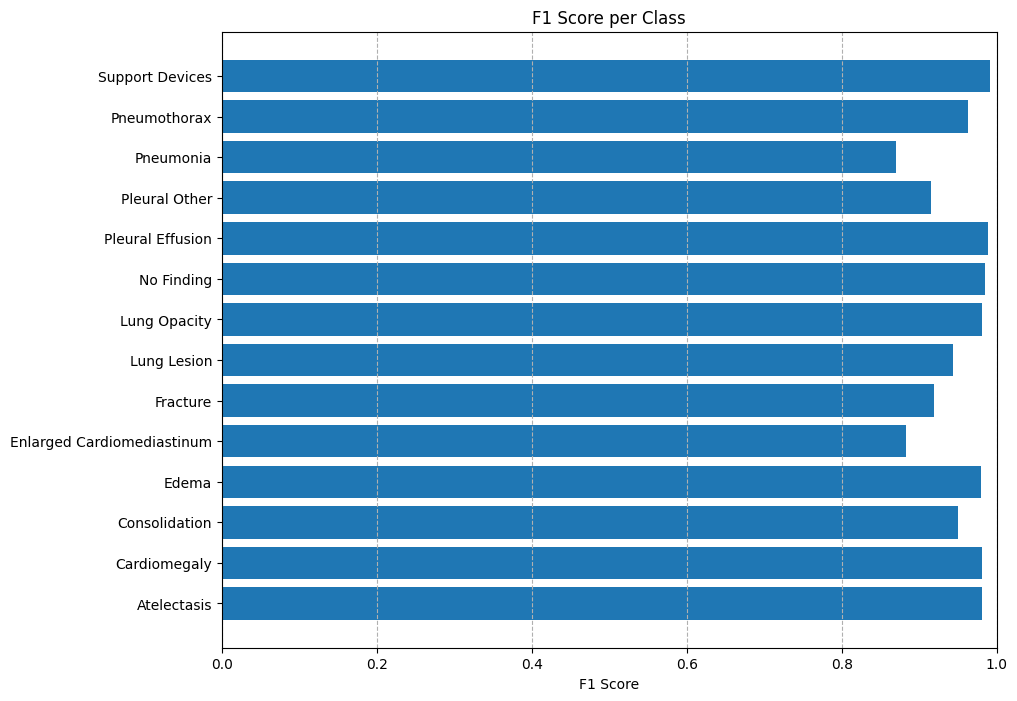

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

report = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True)
class_f1 = {k: v['f1-score'] for k, v in report.items() if k in target_names}

plt.figure(figsize=(10,8))
plt.barh(list(class_f1.keys()), list(class_f1.values()))
plt.title('F1 Score per Class')
plt.xlabel('F1 Score')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--')
plt.show()

## Category distribution and prediction comparison

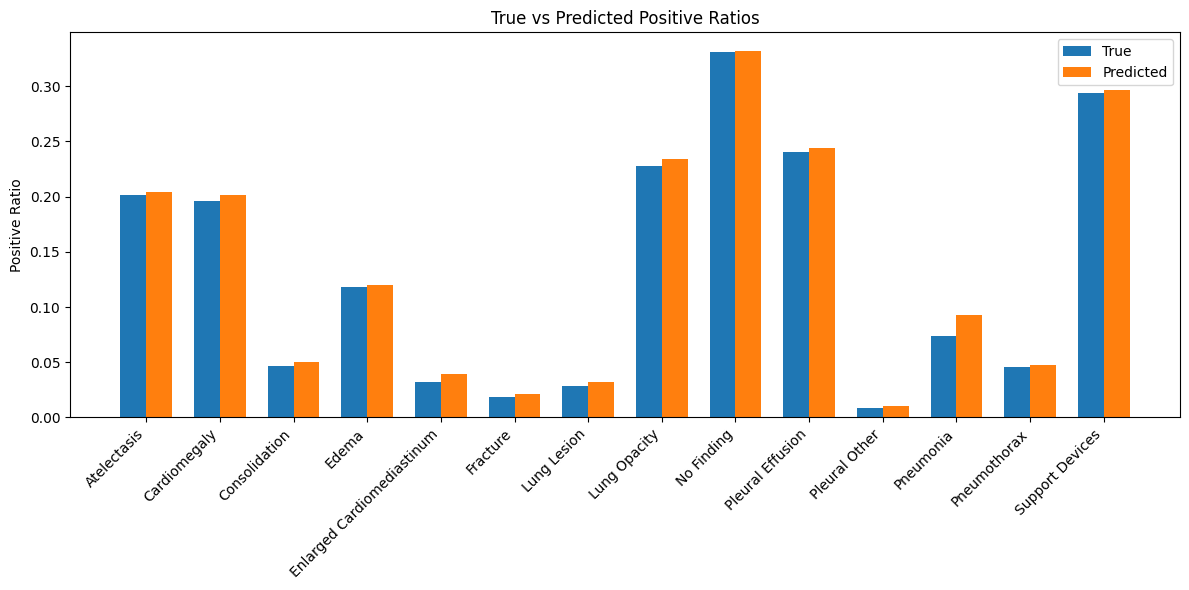

In [ ]:
import numpy as np

true_pos_ratio = all_labels.numpy().mean(axis=0)
pred_pos_ratio = all_preds.numpy().mean(axis=0)

plt.figure(figsize=(12,6))
x = np.arange(len(target_names))
width = 0.35

plt.bar(x - width/2, true_pos_ratio, width, label='True')
plt.bar(x + width/2, pred_pos_ratio, width, label='Predicted')

plt.xticks(x, target_names, rotation=45, ha='right')
plt.ylabel('Positive Ratio')
plt.title('True vs Predicted Positive Ratios')
plt.legend()
plt.tight_layout()
plt.show()